# EXPERIMENTATION NOTEBOOK

In [1]:
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import nibabel as nib
from monai.networks.nets import UNet
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
from monai.transforms import (
    Compose,
    ToTensord,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    NormalizeIntensityd,
    DivisiblePadd
)

ModuleNotFoundError: No module named 'nibabel'

In [2]:
!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
datafile = tarfile.open('Task01_BrainTumour.tar')
datafile.extractall()
datafile.close()

In [3]:
source_path = 'Task01_BrainTumour'

with open(f'{source_path}/dataset.json') as f:
    dataset_json = json.load(f)

NameError: name 'json' is not defined

In [ ]:
dataset_json['training'][:10]

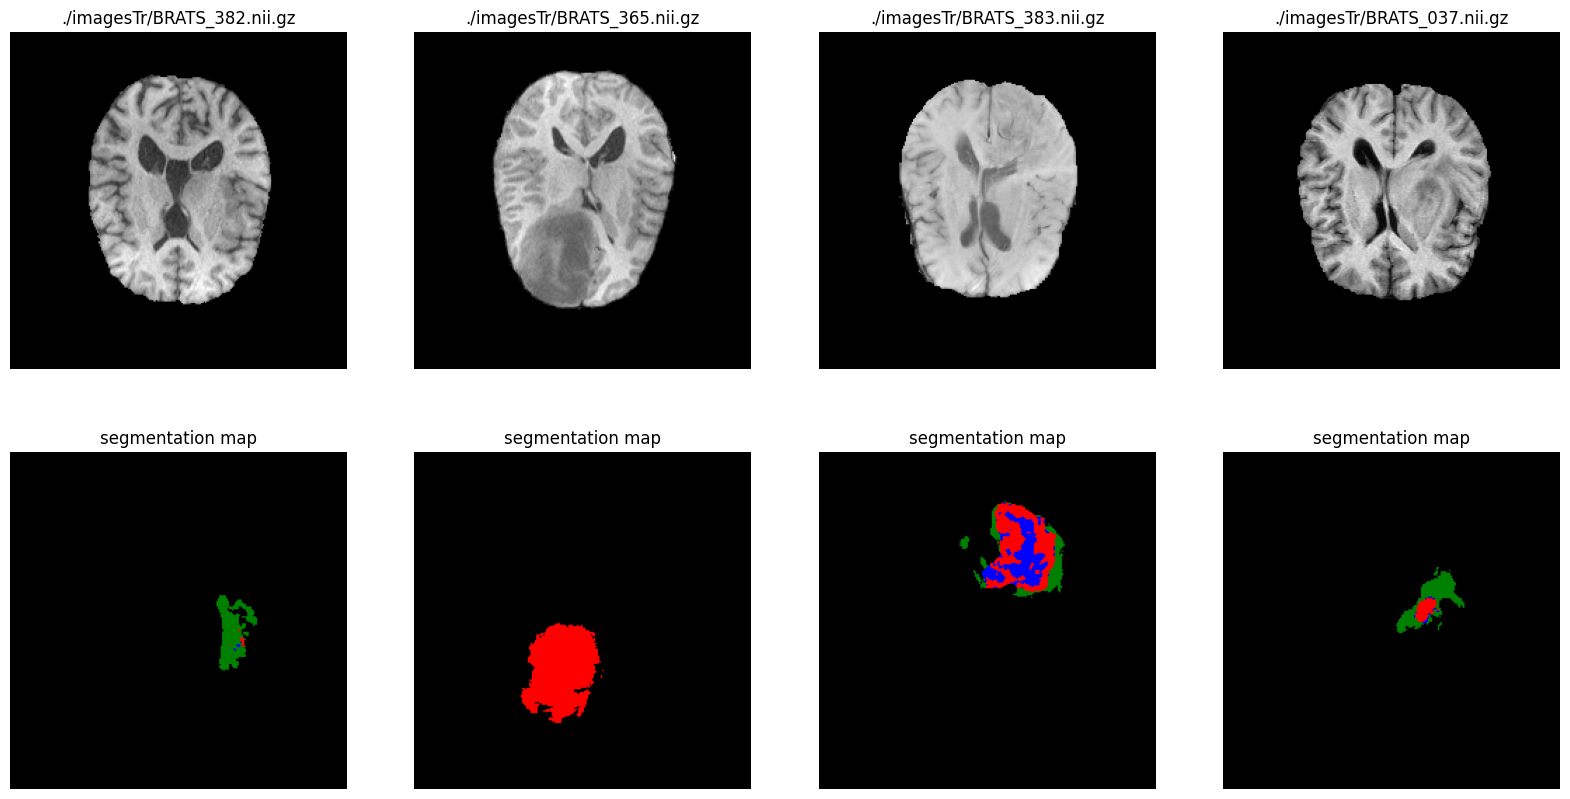

In [5]:
selection = random.sample(dataset_json['training'], 4)
ims, lbs = [], []
modality = 1 # T1, better for general anatomy visualisation

for sample in selection:
    image = nib.load(f"{source_path}/{sample['image']}")
    image_data = image.get_fdata()
    slice_2d = image_data[:, :, image_data.shape[2] // 2]
    ims.append(slice_2d.T[modality])

    label = nib.load(f"{source_path}/{sample['label']}")
    label_data = label.get_fdata()
    slice_2d = label_data[:, :, label_data.shape[2] // 2]
    lbs.append(slice_2d.T)
    
cols = 4
rows = 2
_, axs = plt.subplots(rows, cols, figsize=(20, 10))

for n, (i, l, sample) in enumerate(zip(ims, lbs, selection)):
    axs[0, n].imshow(i, cmap = 'gray')
    axs[0, n].set_title(sample['image'])
    axs[0, n].axis('off')
    axs[1, n].imshow(l, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[1, n].set_title("segmentation map")
    axs[1, n].axis('off')
    
plt.show()

In [42]:
class BrainTumorDataset(Dataset):
    def __init__(self, img_paths, lbl_paths, transforms=None):
        self.img_paths = img_paths
        self.lbl_paths = lbl_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load multi-modal image
        image_nii = nib.load(self.img_paths[idx])
        image = image_nii.get_fdata().transpose(3, 0, 1, 2)  # shape: (4, H, W, D)
        
        label_nii = nib.load(self.lbl_paths[idx])
        label = label_nii.get_fdata()[np.newaxis, ...]  # shape: (1, H, W, D)

        if self.transforms:
            transformed = self.transforms({
                'image': im,
                'label': lb
                })

        image_tensor = transformed['image'].float()
        label_tensor = transformed['label'][0].long()  # for segmentation

        return image_tensor, label_tensor

In [23]:
# 80/20 train/validation split
n = dataset_json['numTraining']
n_train = int(n * 0.8)
n_val = n - n_train

all_list = dataset_json['training']
all_ims = [source_path + sample['image'] for sample in all_list]
all_lbs = [source_path + sample['label'] for sample in all_list]

train_ims, val_ims, train_lbs, val_lbs = train_test_split(all_ims, all_lbs, test_size=0.2, random_state=21)

transform_train = Compose([
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0, 1, 2]),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys="image", factors=0.1, prob=0.7),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.7),
    DivisiblePadd(k=16, keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

transform_val = Compose([
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    DivisiblePadd(k=16, keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

In [50]:
train_dataset = BrainTumorDataset(train_ims, train_lbs, transform_train)
val_dataset = BrainTumorDataset(val_ims, val_lbs, transform_val)

In [52]:
i, l = train_dataset.__getitem__(10)
foreground_mask = i != 0
i.shape, i[foreground_mask].mean(), i[foreground_mask].std()

(torch.Size([4, 240, 240, 160]), metatensor(0.0946), metatensor(0.3863))

In [87]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

In [12]:
IN_MODALITIES=len(dataset_json['modality'])
NUM_CLASSES=len(dataset_json['labels'])

In [91]:
model = UNet(
    spatial_dims=3, 
    in_channels=IN_MODALITIES,   # 4 MRI modalities
    out_channels=NUM_CLASSES,  # 4 output classes
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
)

In [93]:
def dice_loss(pred_softmax, target, epsilon=1e-6):
    # pred_softmax: (N, C, D, H, W)
    # target: (N, D, H, W), integer labels
    num_classes = pred_softmax.shape[1]
    target_onehot = F.one_hot(target, num_classes).permute(0, 4, 1, 2, 3).float()

    intersection = torch.sum(pred_softmax * target_onehot, dim=(2,3,4))
    denom = torch.sum(pred_softmax, dim=(2,3,4)) + torch.sum(target_onehot, dim=(2,3,4))
    dice = (2.0 * intersection + epsilon) / (denom + epsilon)
    return 1 - dice.mean()  # average across classes

In [94]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader)
    for batch_data in progress_bar:
        images, labels = batch_data
        images, labels = images.to(device), labels.to(device)  # move to GPU

        optimizer.zero_grad()
        logits = model(images)  # (N, out_channels, D, H, W)
        pred_softmax = torch.softmax(logits, dim=1)
        
        loss = dice_loss(pred_softmax, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation step...
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_data in tqdm(val_loader):
            images, labels = batch_data
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred_softmax = torch.softmax(logits, dim=1)
            loss = dice_loss(pred_softmax, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")

  0%|                                                                                          | 0/194 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 14988, 15884, 23216, 4512) exited unexpectedly

In [16]:
test_model = UNet(
    spatial_dims=3, 
    in_channels=IN_MODALITIES,   # 4 MRI modalities
    out_channels=NUM_CLASSES,  # 4 output classes
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
)

test_model.load_state_dict(torch.load('unet_3d_model_12.pth'))

C:\Users\sumit\AppData\Local\Temp\ipykernel_8236\1805897677.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('unet_3d_model_12.pth')

<All keys matched successfully>

In [55]:
transform_test = Compose([
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    DivisiblePadd(k=16, keys="image"),
    ToTensord(keys=["image"])
])

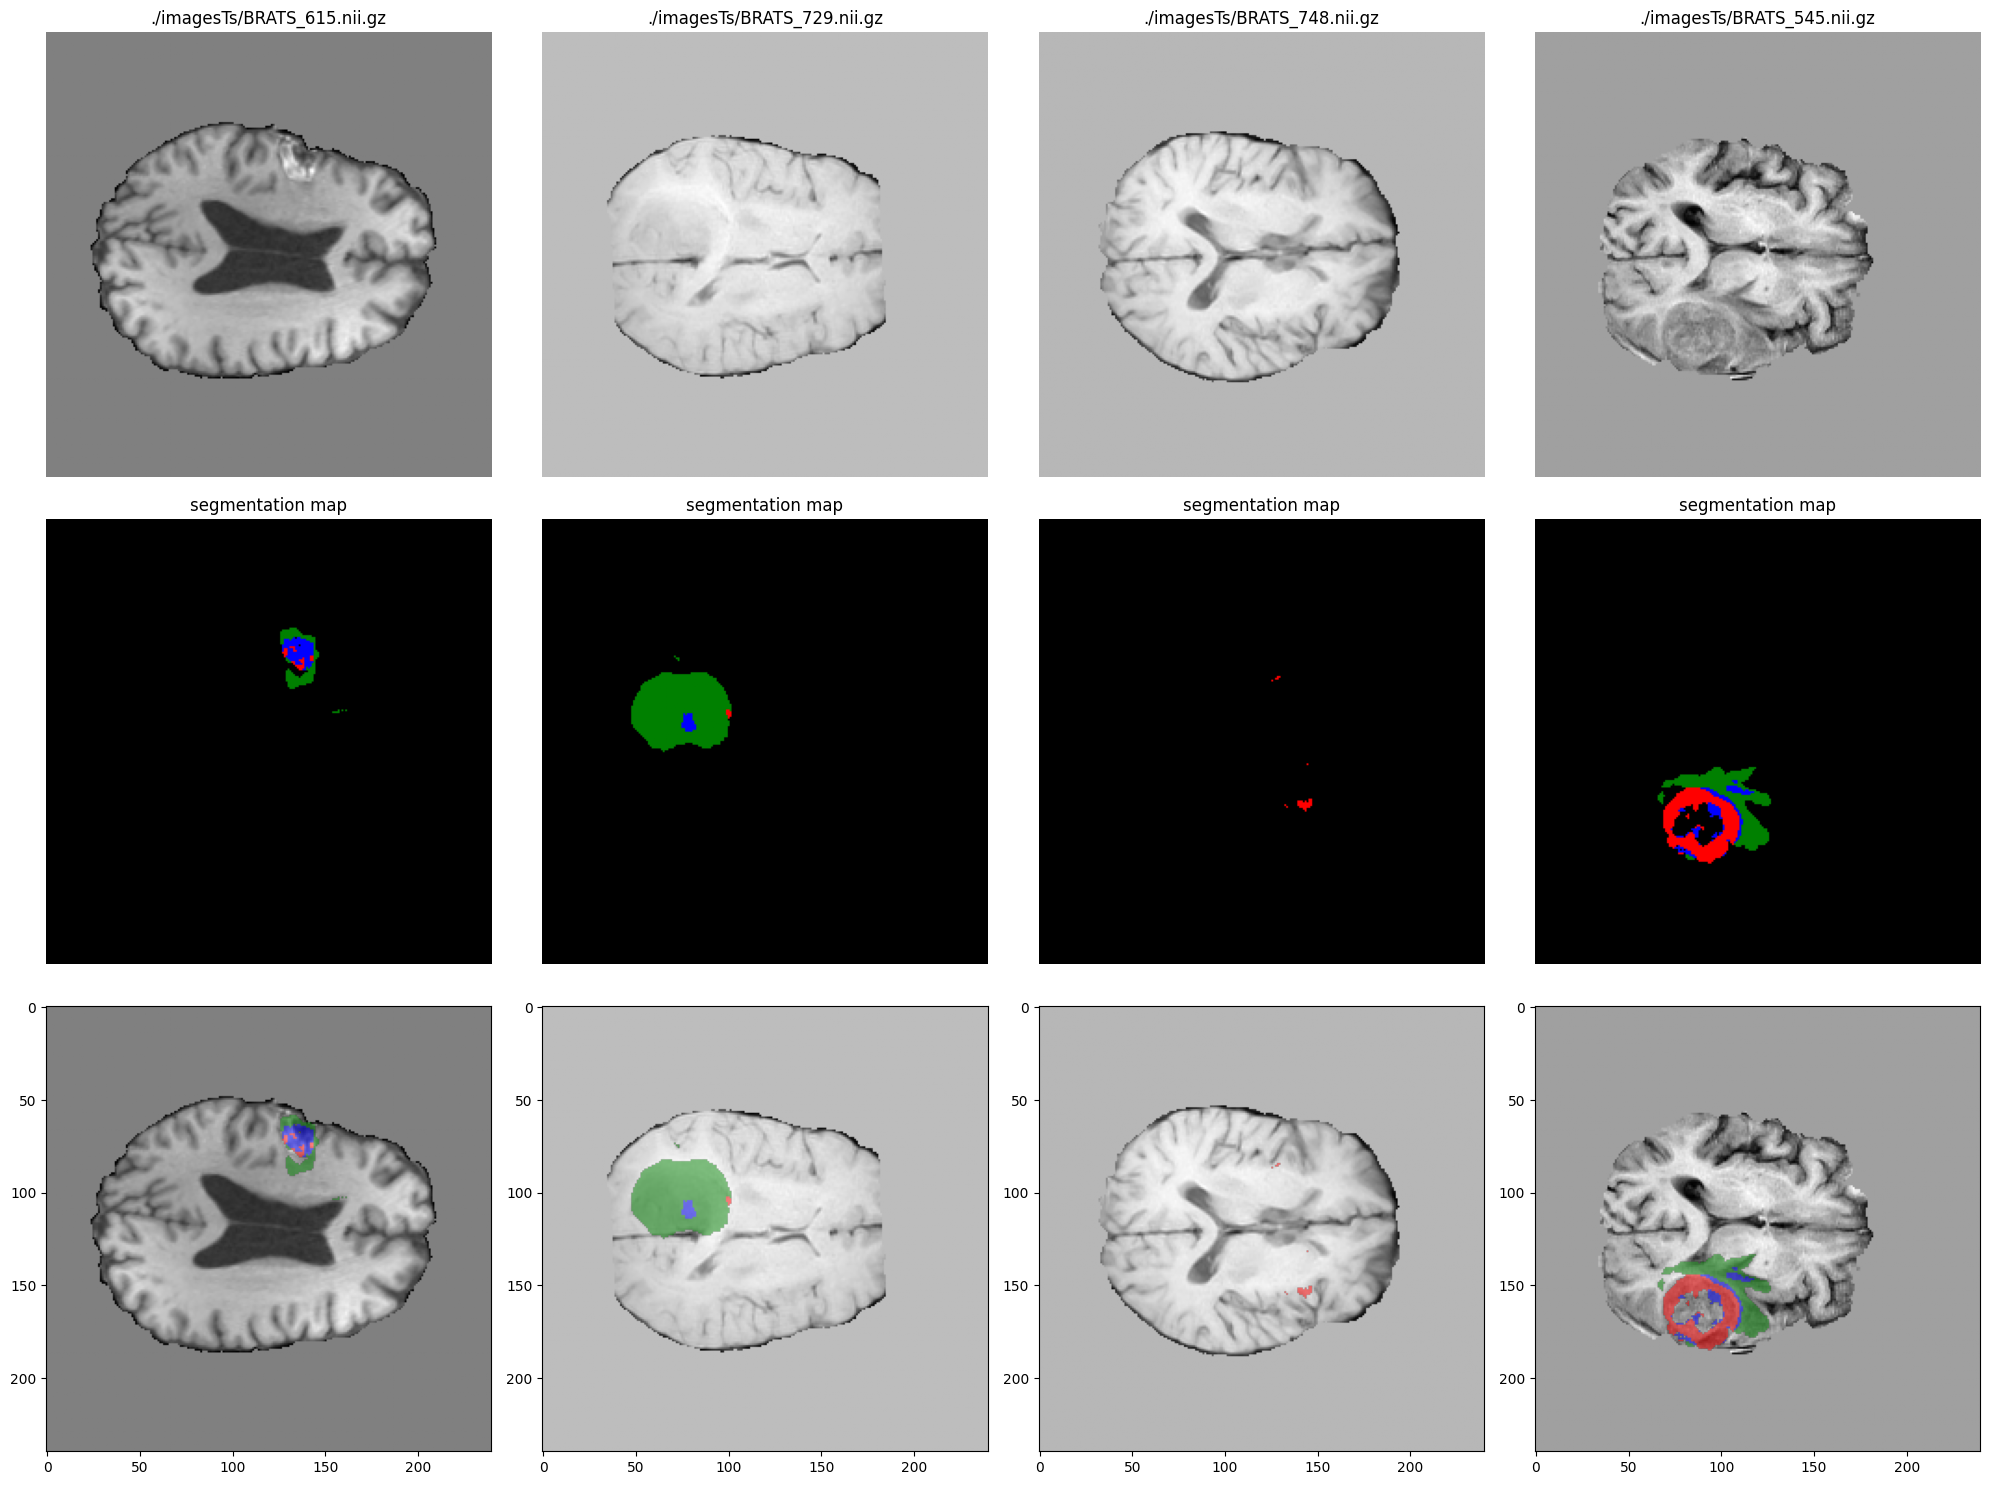

In [101]:
selection = random.sample(dataset_json['test'], 4)
ims, lbs = [], []
modality = 1 # T1, better for general anatomy visualisation

test_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
test_model.to(device)


for sample in selection:
    image = nib.load(f"{source_path}/{sample}")
    image_data = image.get_fdata()

    transformed_im = transform_test({'image': image_data.transpose(3, 0, 1, 2)})['image'].float().to(device)
    with torch.no_grad():
        logits = test_model(transformed_im.unsqueeze(0))
    
    pred_mask = torch.argmax(logits, dim=1)
    pred_label = pred_mask.squeeze(0).cpu().numpy()

    slice_idx = transformed_im.shape[-1] // 2
    ims.append(transformed_im.cpu()[modality, :, :, slice_idx])
    lbs.append(pred_label[:, :, slice_idx])


cols = 4
rows = 3
_, axs = plt.subplots(rows, cols, figsize=(20, 15))

for n, (i, l, sample) in enumerate(zip(ims, lbs, selection)):
    axs[0, n].imshow(i, cmap = 'gray')
    axs[0, n].set_title(sample)
    axs[0, n].axis('off')
    axs[1, n].imshow(l, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axs[1, n].set_title("segmentation map")
    axs[1, n].axis('off')

    axs[2, n].imshow(i, cmap = 'gray')
    axs[2, n].imshow(l, cmap=colors.ListedColormap(['none', 'green', 'blue', 'red']), alpha=0.5)
plt.tight_layout()
plt.show()